In [10]:
import matplotlib.pyplot as plt
from STEMhandler import importEELS
from EELSFits import geteVrange
import numpy as np
from STEMFactorize import PCA
import hyperspy.api as hs

import json
import copy
import math
import matplotlib.patheffects as path_effects
from scipy import interpolate
from sklearn.decomposition import NMF
from skimage.transform import resize
from matplotlib.patches import Rectangle
from pylab import cm

path = "/Users/jiatizhao/Desktop/EELS_sample_data"
HSF_name = 'EELS Spectrum Image_HSF.dm4'
HSR_name = 'EELS Spectrum Image.dm4'

VibData1 = importEELS(HSF_name,path,[2,2])
E_axis = VibData1.getEnergyAxis()
VibData1.normalize(axis=2)
Raw_data = VibData1.dataset

# HSF=np.load(HSF_name,allow_pickle=True)
# HSR=np.load(HSR_name,allow_pickle=True)
# hs.preferences.gui()

In [11]:

HSR_Class = hs.load(HSR_name, signal_type="EELS")
HSF_Class =hs.load(HSF_name, signal_type="EELS")
HSF_Class.data.shape,HSR_Class.data.shape
HSR = HSR_Class.data
HSF = HSF_Class.data

# Input Energy Loss Axis Calibration Values (eV/channel and eV)
disp=0.0002050410082016403;offset=0.025

# Input Spatial Calibration (nm/pixel)
HSF_cal=14.628571428571428
HSR_cal=3.4133333333333336

# Generate Calibrated Energy Loss Axes
E_HSF=np.arange(HSF.shape[2])*disp-offset
E_HSR=np.arange(HSF.shape[2])*disp-offset

# Check if calibrations are identical.
if (E_HSF==E_HSR).all(): 
    E=np.copy(E_HSF)
    print('Identical, please proceed with notebook')
else: print('Non-Identical, re-process datasets to get identical energy loss axes')

Identical, please proceed with notebook


In [12]:
#@title Prepare Datasets for CNMF-PS

# Select cutoff energy
E_cut=0.2
i_cut=np.argmin(np.abs(E-E_cut))

# Create final datasets for PS process
E=E[i_cut:]
HSF=HSF[:,:,i_cut:]
HSR=HSR[:,:,i_cut:]

In [13]:
#@title Perform HSF Decomposition

#Define shapes of HSF and HSR datasets
HSFdim=HSF.shape
HSRdim=HSR.shape

# Choose number of components for CNMF Reconstruction
ncomp=9

# Perform NMF decomposition
HSF_NMF=copy.deepcopy(HSF)
HSF_NMF[HSF_NMF<0]=0
HSF_NMF_flat=HSF_NMF.reshape(np.prod(HSFdim[:2]),HSFdim[2])
HSF_model=NMF(ncomp,max_iter=10000)
HSF_maps=HSF_model.fit_transform(HSF_NMF_flat).reshape(HSFdim[:2]+(ncomp,))
HSF_endmembers=HSF_model.components_

# Resize HSF_maps to the same dimensions as HSR acquisition
HSF_maps_HSR=resize(HSF_maps,HSRdim[:2]+(ncomp,)).reshape(np.prod(HSRdim[:2]),ncomp)

/Users/jiatizhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/jiatizhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [14]:
#@title Perform HSR Decomposition (Note: Only for comparison, not used in CNMF process)

HSR_NMF=copy.deepcopy(HSR)
HSR_NMF[HSR_NMF<0]=0
HSR_NMF_flat=HSR_NMF.reshape(np.prod(HSRdim[:2]),HSRdim[2])
HSR_model=NMF(ncomp,max_iter=10000)
HSR_maps=HSR_model.fit_transform(HSR_NMF_flat).reshape(HSRdim[:2]+(ncomp,))
HSR_endmembers=HSR_model.components_

/Users/jiatizhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/jiatizhao/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [15]:
#@title Perform CNMF Pan-Sharpening of HSR Dataset

PS_NMF=copy.deepcopy(HSR)
PS_NMF[PS_NMF<0]=0
PS_NMF_flat=PS_NMF.reshape(np.prod(HSRdim[:2]),HSRdim[2])
PS_model=NMF(ncomp,init='custom',random_state=0,solver='mu',max_iter=10000)
PS_maps=PS_model.fit_transform(PS_NMF_flat,H=HSF_endmembers, W=HSF_maps_HSR).reshape(HSRdim[:2]+(ncomp,))
PS_endmembers=PS_model.components_

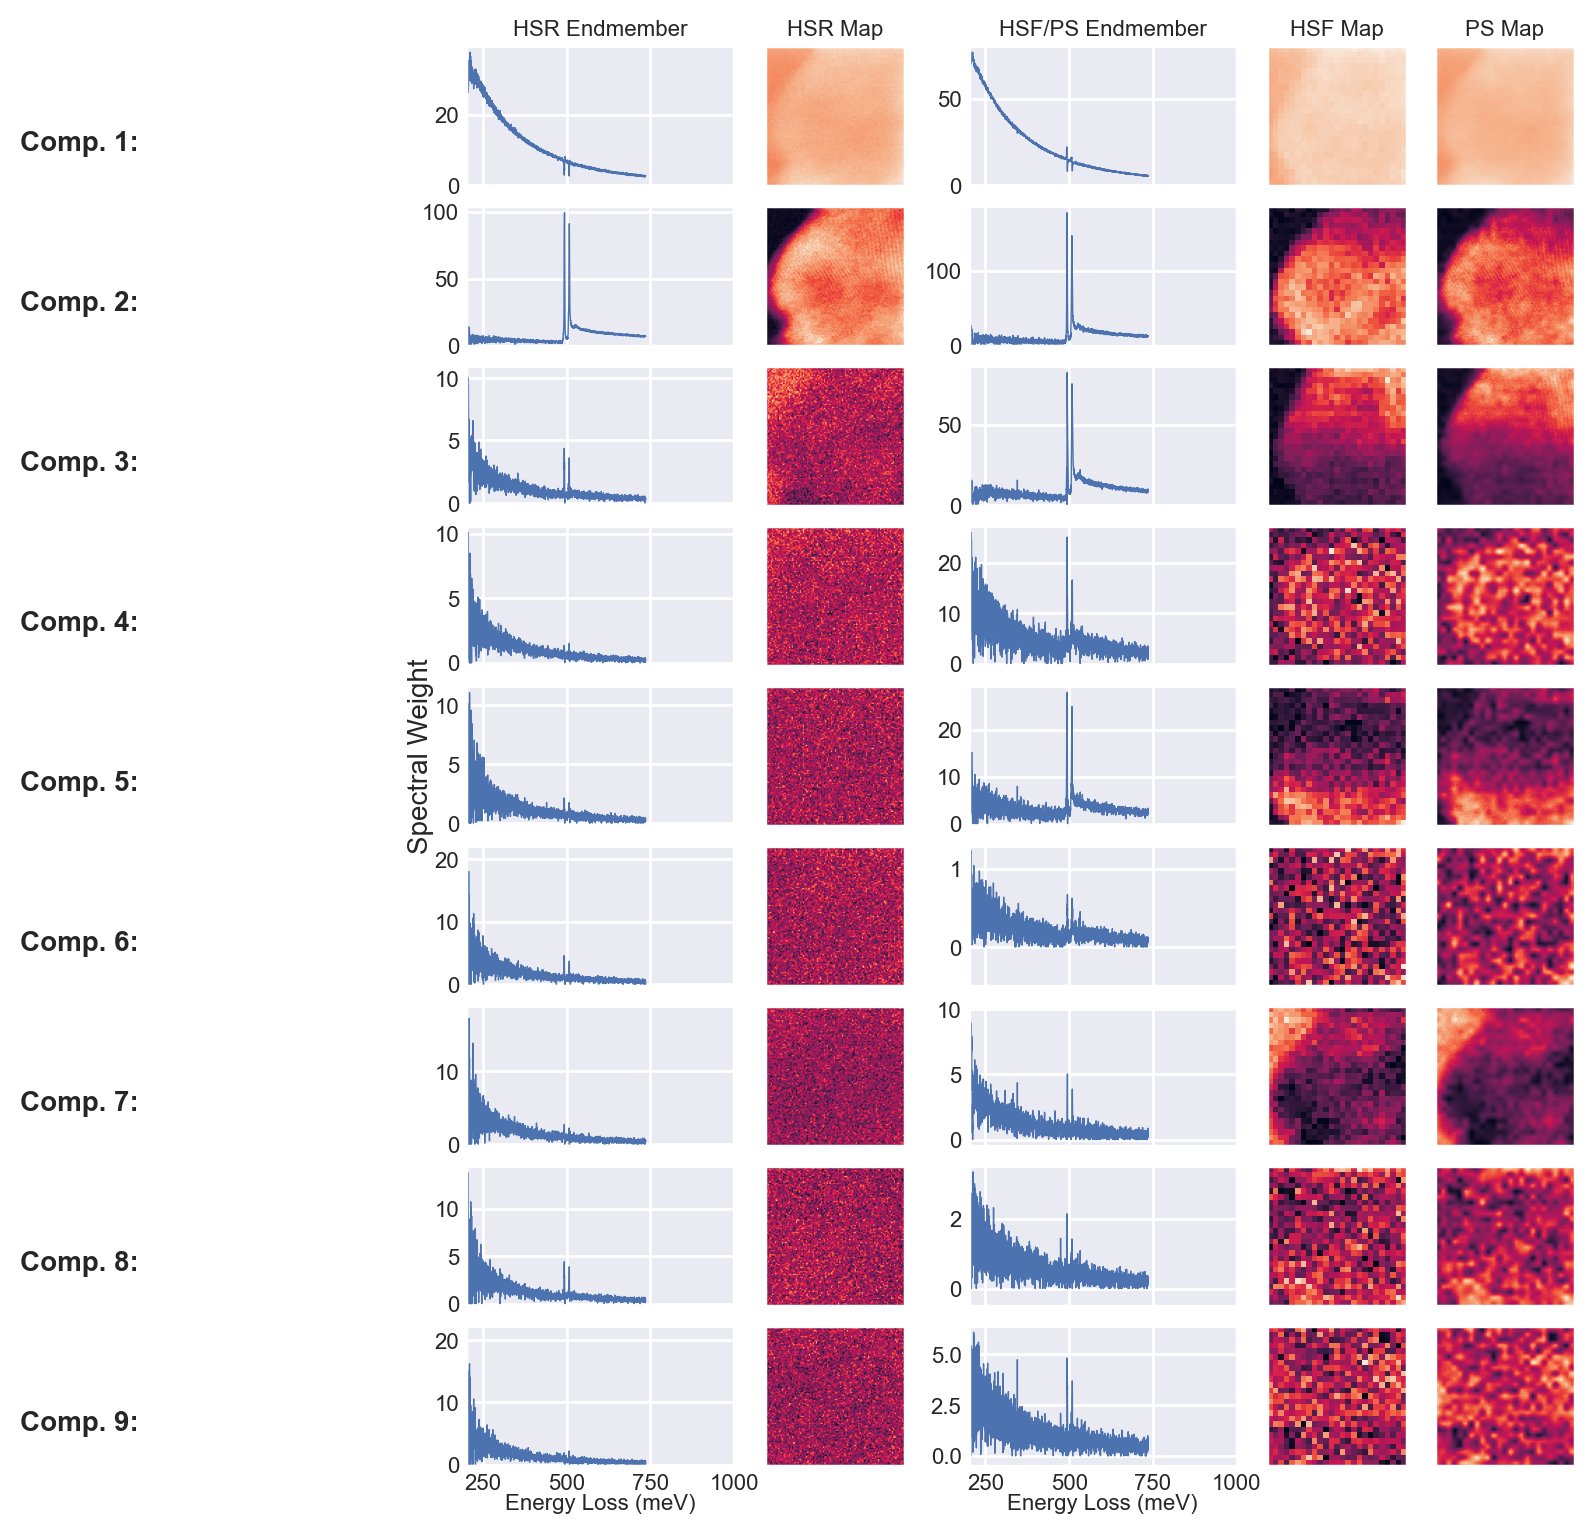

In [16]:
#@title Visualize: Individual Maps and Endmembers

fig=plt.figure(dpi=200,figsize=(6.7,0.8*ncomp))

for i in range(ncomp):
    #Plot HSR Endmembers
    ax=fig.add_axes([0.1,1-(i+1)/ncomp,0.2,0.875/ncomp])
    ax.plot(E*1000,HSR_endmembers[i],color='b',lw=0.5)
    ax.tick_params(labelsize=8,length=2,pad=0.5)
    ax.set_xlim(E[0]*1000,1000);ax.set_ylim(-0.25)
    if i==ncomp-1: ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=0)
    else: ax.set_xticklabels([])
    if i==4: ax.set_ylabel('Spectral Weight',fontsize=10,labelpad=0)
    if i==0: ax.set_title('HSR Endmember',fontsize=8,ha='center',va='center')

    #Plot HSR Abundance Maps
    ax=fig.add_axes([0.3,1-(i+1)/ncomp,0.15,0.875/ncomp],xticks=[],yticks=[])
    ax.imshow(HSR_maps[:,:,i],vmin=0)
    ax.add_patch(Rectangle((4,140),100/HSR_cal,4,fc='w',ec='k',lw=0.5))
    ax.text(-490,78,'Comp. '+str(i+1)+':',fontsize=10,ha='center',va='bottom',fontweight='bold')
    if i==0: ax.set_title('HSR Map',fontsize=8,ha='center',va='center')
    
    #Plot HSF and PS Endmembers
    ax=fig.add_axes([0.475,1-(i+1)/ncomp,0.2,0.875/ncomp])
    ax.plot(E*1000,HSF_endmembers[i],color='b',lw=0.5)
    ax.tick_params(labelsize=8,length=2,pad=0.5)
    ax.set_xlim(E[0]*1000,1000);ax.set_ylim(-0.5)
    if i==0: ax.set_title('HSF/PS Endmember',fontsize=8,ha='center',va='center')
    if i==ncomp-1: ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=0)
    else: ax.set_xticklabels([])
        
    #Plot HSF Abundance Maps
    ax=fig.add_axes([0.675,1-(i+1)/ncomp,0.15,0.875/ncomp],xticks=[],yticks=[])
    ax.imshow(HSF_maps[:,:,i],vmin=0)
    ax.add_patch(Rectangle((1,32),100/HSF_cal,1,fc='w',ec='k',lw=0.5))
    if i==0: ax.set_title('HSF Map',fontsize=8,ha='center',va='center')

    #Plot PS Abundance Maps
    ax=fig.add_axes([0.8,1-(i+1)/ncomp,0.15,0.875/ncomp],xticks=[],yticks=[])
    ax.imshow(PS_maps[:,:,i],vmin=0)
    ax.add_patch(Rectangle((4,140),100/HSR_cal,4,fc='w',ec='k',lw=0.5))     
    if i==0: ax.set_title('PS Map',fontsize=8,ha='center',va='center')

In [17]:
#@title Reconstruct Pan-sharpened dataset

PS=np.reshape(np.matmul(PS_maps,PS_endmembers),HSRdim)
PSmins=np.average(PS[:,:,-50:],axis=2)
PS=(PS.transpose(2,0,1)-PSmins).transpose(1,2,0)

In [ ]:
#@title Visualize: Pan-Sharpened Dataset

# Set energy value for energy-filtered slices of hyperspectral datasets
E_slice=0.425
i_slice=np.argmin(np.abs(E-E_slice))

# Set pixel values for comparison
R1_pix=27,75
R2_pix=10,75

w,h=6.7,5.5;wh=w/h
fig=plt.figure(figsize=(w,h),dpi=200)

#Plot HSR Slice
ax=fig.add_axes([0.055,0.63,0.265,0.265*wh],xticks=[],yticks=[])
ax.imshow(HSR[:,:,i_slice])
ax.add_patch(Rectangle((R1_pix[0]-0.5,R1_pix[1]-0.5),3,3,fc='None',ec='w',lw=1.5))
ax.add_patch(Rectangle((R2_pix[0]-0.5,R2_pix[1]-0.5),3,3,fc='None',ec='w',lw=1.5))
ax.text(R1_pix[0]+0.5,R1_pix[1]-1.5,'1',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.text(R2_pix[0]+0.5,R2_pix[1]-1.5,'2',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.add_patch(Rectangle((6,143),100/HSR_cal,4,fc='w',ec='k',lw=0.5))
txt=ax.text(6+50/HSR_cal,143,'100 nm',color='w',fontweight='bold',fontsize=8,ha='center',va='bottom')
txt.set_path_effects([path_effects.withStroke(linewidth=1, foreground='k')])
ax.set_title('150 x 150 Pixels\n20 ms per Spectrum',fontsize=8,y=0.98)
txt=ax.text(2,2,'A',color='w',fontweight='bold',fontsize=8,ha='left',va='top')
txt.set_path_effects([path_effects.withStroke(linewidth=1,foreground='k')])

#Plot HSR Slice
ax=fig.add_axes([0.385,0.63,0.265,0.265*wh],xticks=[],yticks=[])
ax.imshow(HSF[:,:,i_slice])
R1_pix_HSF=int(R1_pix[0]*HSR_cal/HSF_cal)-1,int(R1_pix[1]*HSR_cal/HSF_cal)
R2_pix_HSF=int(R2_pix[0]*HSR_cal/HSF_cal)-1,int(R2_pix[1]*HSR_cal/HSF_cal)
ax.add_patch(Rectangle((R1_pix_HSF[0]-0.5,R1_pix_HSF[1]-0.5),0.75,0.75,fc='None',ec='w',lw=1.5))
ax.add_patch(Rectangle((R2_pix_HSF[0]-0.5,R2_pix_HSF[1]-0.5),0.75,0.75,fc='None',ec='w',lw=1.5))
ax.text(R1_pix_HSF[0]-0.25,R1_pix_HSF[1]-.75,'1',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.text(R2_pix_HSF[0]-0.25,R2_pix_HSF[1]-.75,'2',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.add_patch(Rectangle((1,32),100/HSF_cal,1,fc='w',ec='k',lw=0.5))
ax.set_title('35 x 35 Pixels\n200 ms per Spectrum',fontsize=8,y=0.98)
txt=ax.text(0.15,0.2,'D',color='w',fontweight='bold',fontsize=8,ha='left',va='top')
txt.set_path_effects([path_effects.withStroke(linewidth=1,foreground='k')])

#Plot PS Slice
ax=fig.add_axes([0.715,0.63,0.265,0.265*wh],xticks=[],yticks=[])
ax.imshow(PS[:,:,i_slice])
ax.add_patch(Rectangle((R1_pix[0]-0.5,R1_pix[1]-0.5),3,3,fc='None',ec='w',lw=1.5))
ax.add_patch(Rectangle((R2_pix[0]-0.5,R2_pix[1]-0.5),3,3,fc='None',ec='w',lw=1.5))
ax.text(R1_pix[0]+0.5,R1_pix[1]-1.5,'1',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.text(R2_pix[0]+0.5,R2_pix[1]-1.5,'2',fontweight='bold',color='w',fontsize=8,va='bottom',ha='center')
ax.add_patch(Rectangle((6,143),100/HSR_cal,4,fc='w',ec='k',lw=0.5))
ax.set_title('Pan-Sharpened\nSpectrum Image',fontsize=8,y=0.98)
txt=ax.text(2,2,'G',color='w',fontweight='bold',fontsize=8,ha='left',va='top')
txt.set_path_effects([path_effects.withStroke(linewidth=1,foreground='k')])

#Plot HSR Representative Spectrum
ax=fig.add_axes([0.055,0.3425,0.265,0.275])
ax.plot(E*1000,HSR[R1_pix[1],R1_pix[0]],color='b',lw=0.5)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.set_ylabel('Position 1 Int. (Counts)',fontsize=8,labelpad=-1)
ax.set_ylim(-15,120)
ax.text(E[0]*1000+10,ax.get_ylim()[1]*0.98,'B',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')
ax.set_xticklabels([])

ax=fig.add_axes([0.055,0.055,0.265,0.275])
ax.plot(E*1000,HSR[R2_pix[1],R2_pix[0]],color='b',lw=0.5)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=2)
ax.set_ylabel('Position 2 Int. (Counts)',fontsize=8,labelpad=-1)
ax.set_ylim(-15,100)
ax.text(E[0]*1000+10,ax.get_ylim()[1]*0.98,'C',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')

#Plot HSF Representative Spectrum
ax=fig.add_axes([0.385,0.3425,0.265,0.275])
ax.plot(E*1000,HSF[R1_pix_HSF[1],R1_pix_HSF[0]],color='b',lw=1)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.text(E[0]*1000+10,ax.get_ylim()[1]*0.98,'E',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')
ax.set_xticklabels([])

ax=fig.add_axes([0.385,0.055,0.265,0.275])
ax.plot(E*1000,HSF[R2_pix_HSF[1],R2_pix_HSF[0]],color='b',lw=1)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.text(E[0]*1000+10,ax.get_ylim()[1]*0.98,'F',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')
ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=2)

#Plot PS Representative Spectrum
ax=fig.add_axes([0.715,0.3425,0.265,0.275])
ax.plot(E*1000,PS[R1_pix[1],R1_pix[0]],color='b',lw=1)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=2)
ax.text(E[0]*1000+10,ax.get_ylim()[1]*0.98,'H',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')
ax.set_xticklabels([])

ax=fig.add_axes([0.715,0.055,0.265,0.275])
ax.plot(E*1000,PS[R2_pix[1],R2_pix[0]],color='b',lw=1)
ax.tick_params(labelsize=8,length=2,pad=0.5)
ax.set_xlim(E[0]*1000,1000)
ax.axhline(0,lw=1,ls='--',color='k')
ax.set_xlabel('Energy Loss (meV)',fontsize=8,labelpad=2)
ax.text(E[0]*1000+10,ax.get_ylim()[1]*0.98,'I',ha='left',va='top',fontweight='bold',fontsize=8)
ax.axvline(E_slice*1000,color='k',lw=1.5,ls='--')